In [1]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time as pytime
import statsmodels.tsa.stattools as tsa
import ruptures as rpt
import InsanallyLabEphysTools as ilep
import OldDecodingTools as odt
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model
from itertools import product
from datetime import datetime
from matplotlib.backends.backend_pdf import PdfPages
import h5py
#import tables as tb
from copy import deepcopy
import colorsys
import pingouin as pg

from sklearn.model_selection import GridSearchCV, StratifiedKFold, LeaveOneOut
from sklearn.neighbors import KernelDensity

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'
GOOD_GREY = '#969696'
GOOD_GREEN = '#32A852'
SWITCH_COLOR = '#B07A3B'
NCR_CR_cmap = mpl.colors.LinearSegmentedColormap.from_list('NCR-CR color map', [NCR_COLOR, CR_COLOR], N=1000)

#act_directory = '/Users/InsanallyLab/Desktop/Analysis_Cache'
act_directory = 'C:\\Users\insan\\Desktop\\Analysis_Cache'
#ops_directory = 'D:\\Opsin_Cache'
#beh_directory = 'P:\\Behavioor'

%run animal_info
ANIMAL = 'AC_12102016'

#animalstouse = ['BS_40','BS_41','BS_42','BS_49','BS_51','BS_56','BS_59','BS_61','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_19']

dualanimalnames = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_61','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_19']
opsinanimalnames = ['BS_86','BS_92','BS_100','BS_103','BS_111','BS_119','BS_123','BS_128','BS_131','BS_139','BS_163','BS_165','BS_174','BS_179','BS_191','BS_192']
tuninganimalnames = ['BS_173','BS_175','BS_187','BS_188','BS_213','BS_214','AE_235','AE_236','TH_237']
unuseddualanimals = ['BS_78']

dualanimals = ['BS_174','BS_179','BS_191','BS_192']
retroanimals = ['PB_86','BS_86','PB_92','BS_92','BS_100','BS_103','BS_111','BS_119','BS_123','BS_128','BS_131','BS_139','BS_163','BS_165']
didlearnopsinanimals = ['BS_92','BS_103','BS_111','BS_179']
didnotlearnopsinanimals = ['BS_86','BS_100','BS_119','BS_123','BS_128','BS_131','BS_163','BS_174']
indeterminateopsinanimals = ['BS_139','BS_165','BS_191','BS_192']

In [2]:
animals_in_cache = []
for session in tqdm(os.listdir(act_directory)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    animals_in_cache.append(sessionfile.meta.animal)
# for session in tqdm(os.listdir(ops_directory)):
#     sessionfile = ilep.loadSessionCached(ops_directory,session)
#     animals_in_cache.append(sessionfile.meta.animal)
animals_in_cache = np.unique(animals_in_cache)

training_days_recorded = dict()
for animal in animals_in_cache:
    training_days_recorded[animal] = []
    
for session in tqdm(os.listdir(act_directory)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    if sessionfile.meta.region != 'AC':
        continue
    training_days_recorded[sessionfile.meta.animal].append(sessionfile.meta.day_of_training)
# for session in tqdm(os.listdir(ops_directory)):
#     sessionfile = ilep.loadSessionCached(ops_directory,session)
#     if sessionfile.meta.region != 'AC':
#         continue
#     training_days_recorded[sessionfile.meta.animal].append(sessionfile.meta.day_of_training)
print(animals_in_cache)

100%|██████████| 516/516 [00:02<00:00, 206.37it/s]

['AE_229' 'AE_235' 'AE_236' 'BS_108' 'BS_113' 'BS_173' 'BS_175' 'BS_187'
 'BS_188' 'BS_213' 'BS_214' 'BS_33' 'BS_40' 'BS_41' 'BS_42' 'BS_49'
 'BS_50' 'BS_51' 'BS_56' 'BS_59' 'BS_67' 'BS_70' 'BS_72' 'BS_73' 'BS_78'
 'BS_83' 'BS_85' 'BS_87' 'BS_95' 'DS_15' 'DS_16' 'DS_17' 'DS_19' 'DS_22'
 'LA_204' 'LA_205' 'TH_200' 'TH_201' 'TH_203' 'TH_217' 'TH_230' 'TH_233'
 'TH_234' 'TH_237']


In [3]:
firstExpert = SimpleNamespace()
firstExpert.pre = dict()
firstExpert.post = dict()

#Tuning Animals
firstExpert.pre['BS_173'] = 14
firstExpert.pre['BS_175'] = 10
firstExpert.pre['BS_187'] = 6
firstExpert.pre['BS_188'] = 5
firstExpert.pre['BS_213'] = 6
firstExpert.pre['BS_214'] = np.Inf
firstExpert.pre['TH_217'] = 18
firstExpert.pre['AE_235'] = np.Inf ### Pending
firstExpert.pre['AE_236'] = np.Inf ### Pending
firstExpert.pre['TH_237'] = np.Inf ### Pending

firstExpert.post['BS_173'] = 28
firstExpert.post['BS_175'] = 27
firstExpert.post['BS_187'] = 15
firstExpert.post['BS_188'] = 18
firstExpert.post['BS_213'] = np.Inf
firstExpert.post['BS_214'] = np.Inf
#firstExpert.post['TH_217'] = np.Inf ### Pending
firstExpert.post['AE_235'] = np.Inf ### Pending
firstExpert.post['AE_236'] = np.Inf ### Pending
firstExpert.post['TH_237'] = np.Inf ### Pending

#Dual recording animals
firstExpert.pre['BS_40'] = 16 # Maybe 17
firstExpert.pre['BS_41'] = 4
firstExpert.pre['BS_42'] = 5
firstExpert.pre['BS_49'] = 12
firstExpert.pre['BS_50'] = 10
firstExpert.pre['BS_51'] = 6
firstExpert.pre['BS_56'] = 6
firstExpert.pre['BS_59'] = 4
firstExpert.pre['BS_67'] = 4 #Maybe 5. 68% and 1.6
firstExpert.pre['BS_70'] = 6
firstExpert.pre['BS_72'] = 4
firstExpert.pre['BS_87'] = 4
firstExpert.pre['BS_108'] = 5
firstExpert.pre['DS_15'] = 9
firstExpert.pre['DS_19'] = 10

firstExpert.post['BS_40'] = 30
firstExpert.post['BS_41'] = 16
firstExpert.post['BS_42'] = 15
firstExpert.post['BS_49'] = 18
firstExpert.post['BS_50'] = np.Inf
firstExpert.post['BS_51'] = 17
firstExpert.post['BS_56'] = 14
firstExpert.post['BS_59'] = 13
firstExpert.post['BS_67'] = 13
firstExpert.post['BS_70'] = 18
firstExpert.post['BS_72'] = 19
firstExpert.post['BS_87'] = 13
firstExpert.post['BS_108'] = 15
firstExpert.post['DS_15'] = 25 #Double-check this
firstExpert.post['DS_19'] = 23

In [4]:
#dualnames = ['BS_108','BS_113','BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_70','BS_72','BS_83','BS_85','BS_87','BS_95']
#animalnames = dualnames

#Animals missing:
#113,50,83,95
#Animals added:
#61,67,15,16,17,19,22

#animalnames = ['BS_40','BS_41','BS_42','BS_49','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_19']
dualanimalnames = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_19']
#opsinanimalnames = ['BS_86','BS_92','BS_100','BS_103','BS_111','BS_119','BS_123','BS_128','BS_131','BS_139','BS_163','BS_165','BS_174','BS_179','BS_191','BS_192']
tuninganimalnames = ['BS_173','BS_175','BS_187','BS_188','BS_213','BS_214','TH_217','AE_235','AE_236','TH_237']
unuseddualanimals = ['BS_78']

animalnames = np.concatenate([dualanimalnames,tuninganimalnames,unuseddualanimals])

animals = dict()
for animal in animalnames:
    animals[animal] = SimpleNamespace()
    animals[animal].name = animal
    
#Dual Recording Animals
#animals['BS_33'].reversal = 20
animals['BS_67'].reversal = 7
#animals['BS_73'].reversal = np.nan
animals['BS_78'].reversal = np.nan
animals['BS_108'].reversal = 7
#animals['BS_113'].reversal = 13
animals['BS_40'].reversal = 18
animals['BS_41'].reversal = 6
animals['BS_42'].reversal = 7
animals['BS_49'].reversal = 13
animals['BS_50'].reversal = 12
animals['BS_51'].reversal = 8
#animals['BS_52'].reversal = 15
animals['BS_56'].reversal = 8
animals['BS_59'].reversal = 7
#animals['BS_61'].reversal = 9    ###
animals['BS_70'].reversal = 8
animals['BS_72'].reversal = 6
#animals['BS_83'].reversal = 20
#animals['BS_85'].reversal = 10
animals['BS_87'].reversal = 6
#animals['DS_16'].reversal = 11
#animals['BS_95'].reversal = 8
animals['DS_15'].reversal = 12
animals['DS_19'].reversal = 12

#Opsin Animals
# animals['BS_86'].reversal = 14
# animals['BS_92'].reversal = 9
# animals['BS_100'].reversal = 11
# animals['BS_103'].reversal = 8
# animals['BS_111'].reversal = 8
# animals['BS_119'].reversal = 10
# animals['BS_123'].reversal = 9
# animals['BS_128'].reversal = 6
# animals['BS_131'].reversal = 14
# animals['BS_139'].reversal = 10
# animals['BS_163'].reversal = 13
# animals['BS_165'].reversal = np.Inf
# animals['BS_174'].reversal = 14
# animals['BS_179'].reversal = 16
# animals['BS_191'].reversal = 10
# animals['BS_192'].reversal = 7

#Tuning Animals
animals['BS_173'].reversal = 15
animals['BS_175'].reversal = 11
animals['BS_187'].reversal = 8
animals['BS_188'].reversal = 8
animals['BS_213'].reversal = 8
animals['BS_214'].reversal = np.Inf
animals['TH_217'].reversal = 20
animals['AE_235'].reversal = 20
animals['AE_236'].reversal = 20
animals['TH_237'].reversal = 20

print([a for a in animals])

['BS_40', 'BS_41', 'BS_42', 'BS_49', 'BS_50', 'BS_51', 'BS_56', 'BS_59', 'BS_67', 'BS_70', 'BS_72', 'BS_87', 'BS_108', 'DS_15', 'DS_19', 'BS_173', 'BS_175', 'BS_187', 'BS_188', 'BS_213', 'BS_214', 'TH_217', 'AE_235', 'AE_236', 'TH_237', 'BS_78']


BS_40
6
BS_41
3
BS_42
3
BS_49
2
BS_50
7
BS_51
6
BS_56
4
BS_59
3
BS_67
4
BS_70
5
BS_72
3
BS_87
4
BS_108
3
DS_15
7
DS_19
4
BS_173
2
BS_175
1
BS_187
4
BS_188
5
BS_213
6
BS_214
BS_214 has no post-reversal
inf
TH_217
TH_217 has no post-reversal
10
AE_235
AE_235 has no post-reversal
4
AE_236
AE_236 has no post-reversal
5
TH_237
TH_237 has no post-reversal
7
BS_78
BS_78 has no post-reversal
inf


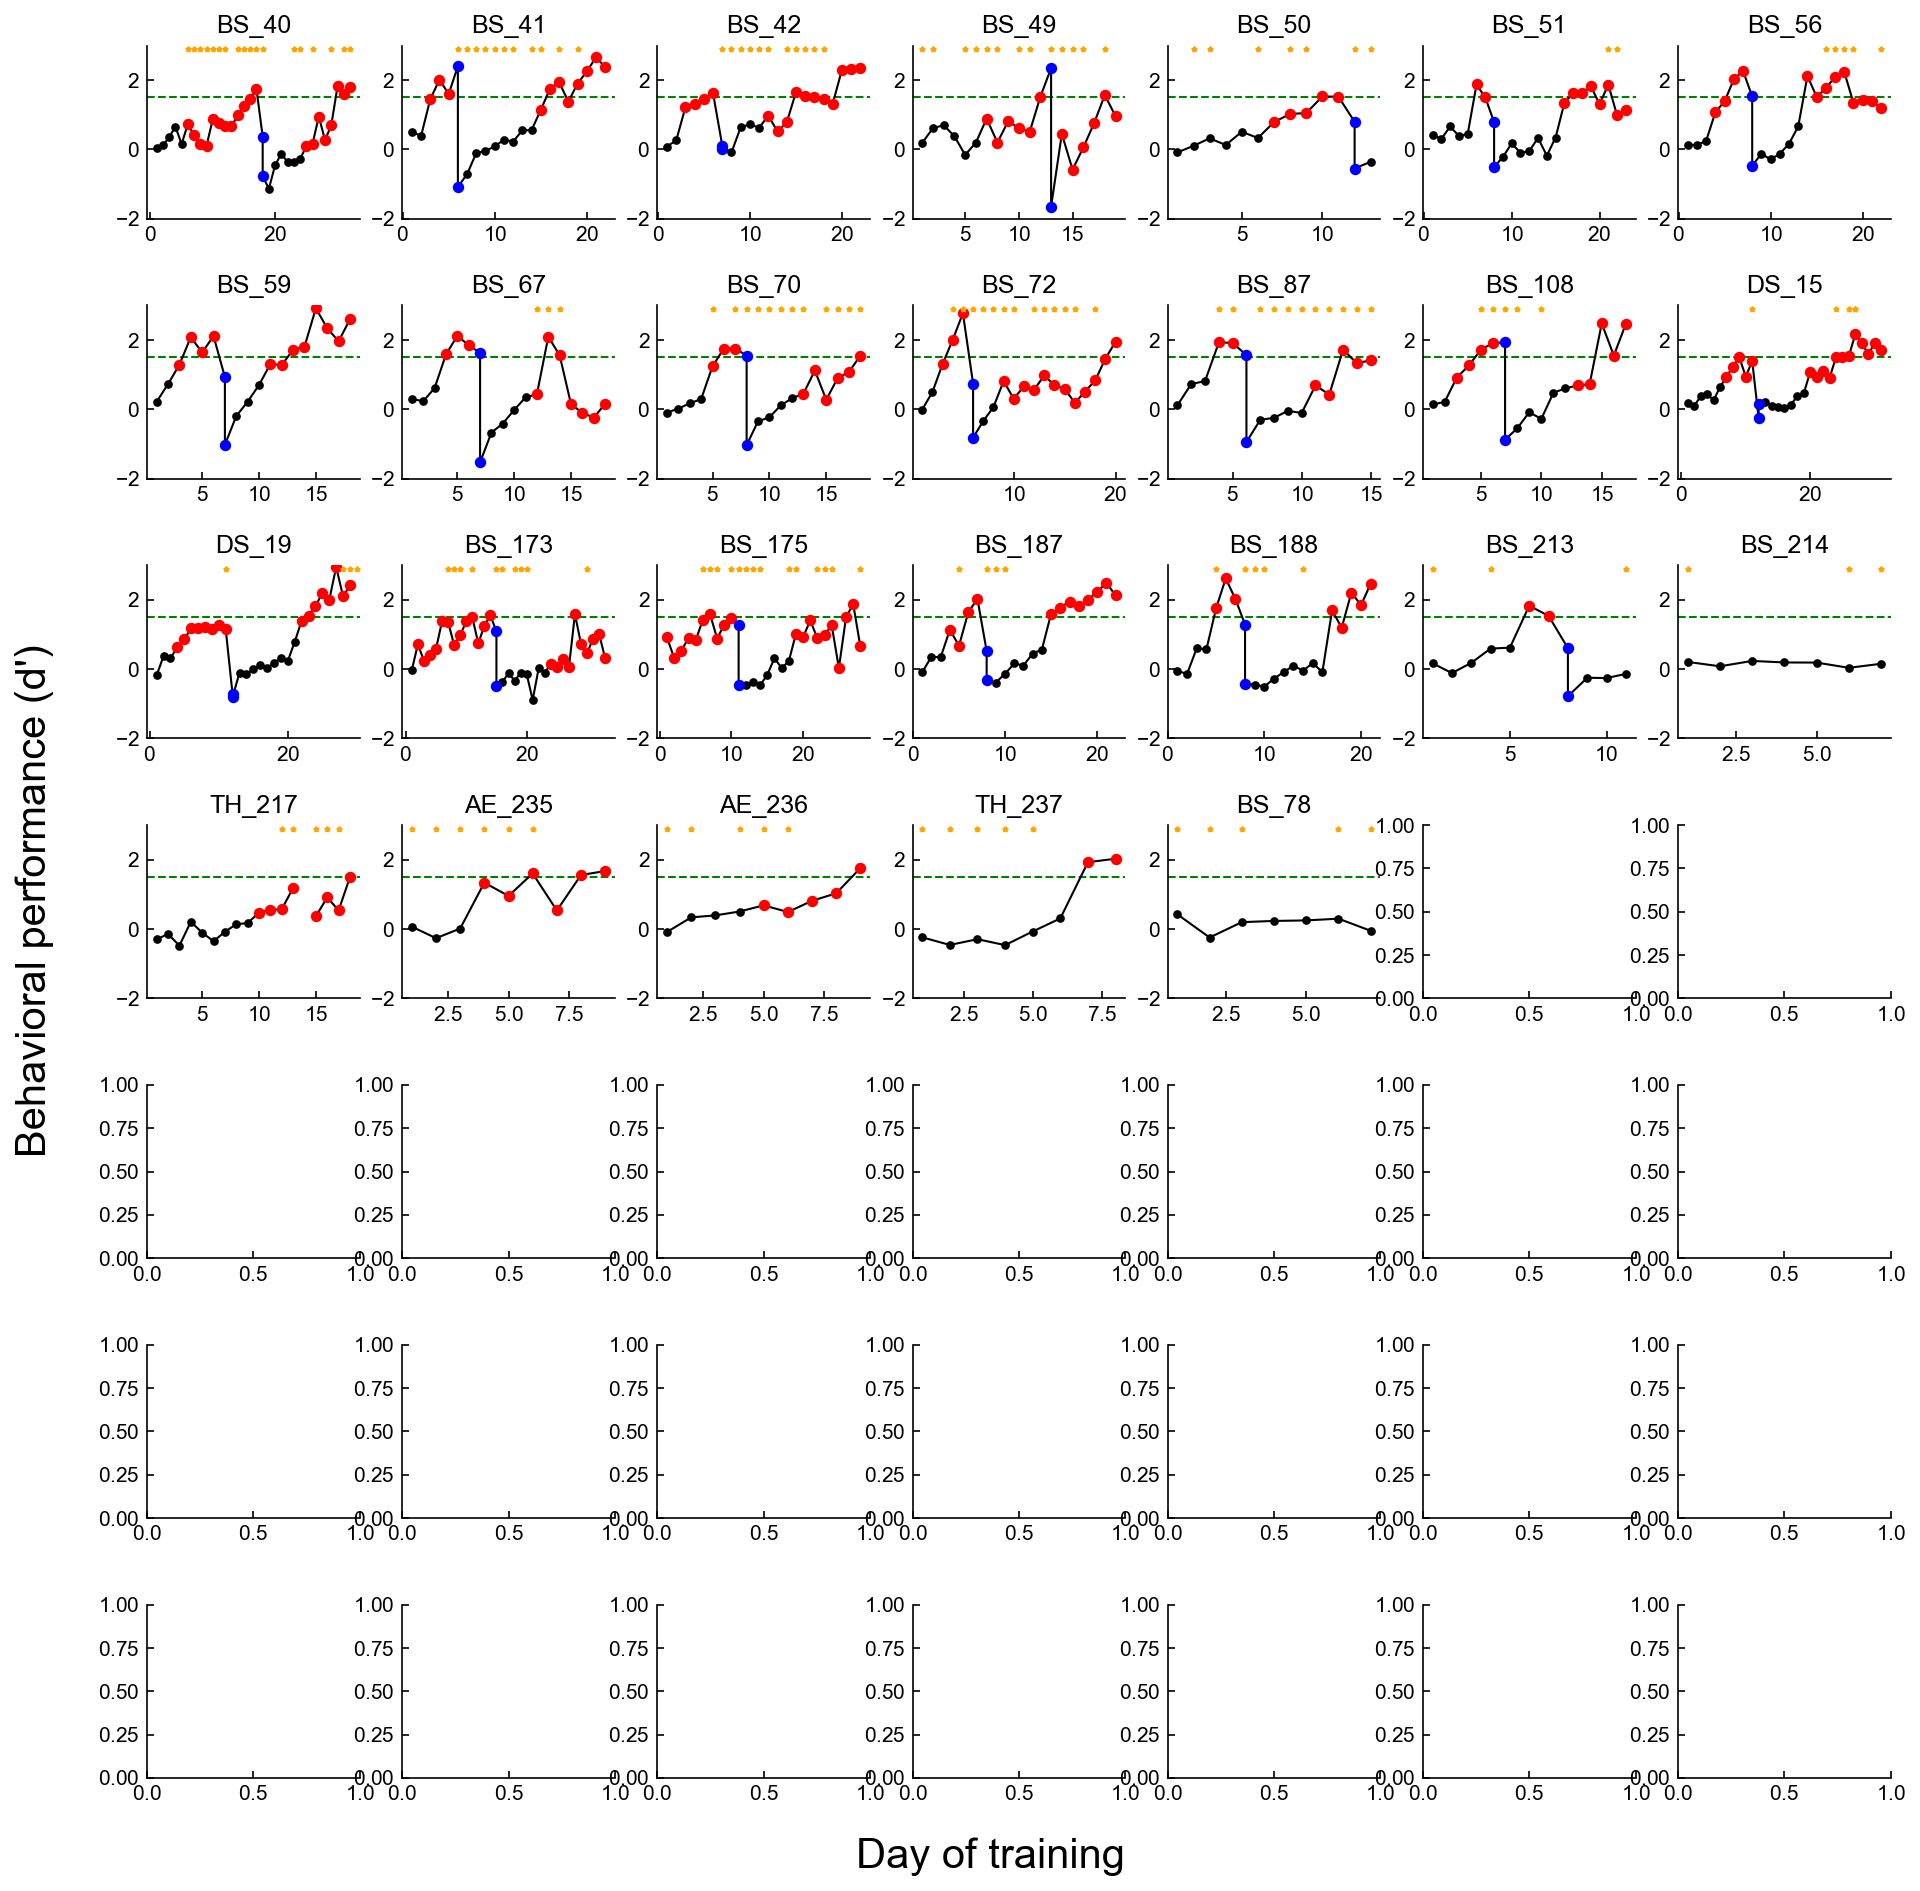

In [5]:
#filename = os.path.join('/Users/InsanallyLab/Desktop/DataForJMTTotal.csv')
filename = os.path.join('C:\\\\Users','insan','Desktop','DataForJMTTotal.csv')
csv = pd.read_csv(filename)

postthresholds = dict()

plot=True
if plot:
    fig = plt.figure(figsize=(15,15))
    gs = fig.add_gridspec(7,7,hspace=0.5)
    axs = [plt.subplot(gs[i,j]) for i,j in product(range(7),range(7))]
    #plt.delaxes(axs[14])
    #plt.delaxes(axs[15])

premiddlecutoffs = dict()
postmiddlecutoffs = dict()
PERphases = dict()

for animalidx,animal in enumerate(animals):
    print(animal)
    PERphases[animal] = dict()
    
    condname = 'd\' ' + animal
    pc_condname = 'Percent correct ' + animal
    days = np.array(list(csv['Day']))
    cond = csv[condname]
    cond_pc = csv[pc_condname]
    
    #Correct for double reversal days
    for idx,day in enumerate(days):
        if day > animals[animal].reversal:
            days[idx] = day-1
            
        if day > animals[animal].reversal+1: #  +1 because the csv stores the switch day as two entries
            #Calculate PERphase
            PC = cond_pc[idx]
            if PC <= 47.5:
                PERphases[animal][day-1] = 'perseveration'
            elif PC >= 52.5:
                PERphases[animal][day-1] = 'refinement'
            else:
                PERphases[animal][day-1] = 'exploration'
            
    #days = days - animals[animal].reversal
    
    prereversaldays = []
    prereversaldps = []
    maxreversaldp = -np.Inf
    minreversaldp = np.Inf
    postreversaldays = []
    postreversaldps = []
    for idx,day in enumerate(days):
        if day < animals[animal].reversal or np.isnan(animals[animal].reversal):
            prereversaldays.append(day)
            prereversaldps.append(cond[idx])
        if day == animals[animal].reversal:
            maxreversaldp = max(cond[idx],maxreversaldp)
            minreversaldp = min(cond[idx],minreversaldp)
        if day > animals[animal].reversal and not np.isnan(cond[idx]):
            postreversaldays.append(day)
            postreversaldps.append(cond[idx])
            
    #Prereversal threshold
    maxperf = np.nanmax(np.concatenate((prereversaldps,[1.5])))
    minperf = np.nanmin(prereversaldps)
    prethreshold = minperf + 0.4*(maxperf-minperf)
    #Postreversal threshold
    try:
        maxperf = np.nanmax(np.concatenate((postreversaldps,[1.5])))
        minperf = np.nanmin(postreversaldps)
    except:
        print(animal+' has no post-reversal')
        maxperf = np.nan
        minperf = np.nan
    postthreshold = minperf + 0.4*(maxperf-minperf)
    
    postthresholds[animal] = postthreshold
    
    prereversaldays = np.array(prereversaldays)
    prereversaldps = np.array(prereversaldps)
    postreversaldays = np.array(postreversaldays)
    postreversaldps = np.array(postreversaldps)
    
    premiddlebool = np.greater_equal(prereversaldps,prethreshold)
    for idx,day in enumerate(prereversaldays):
        if premiddlebool[idx]:
            premiddlebool[idx:(len(premiddlebool)-1)].fill(True)
        #if not premiddlebool[idx]:
        #    premiddlebool[0:idx].fill(False)
    if np.any(premiddlebool):
        premiddlefirstday = np.min(prereversaldays[premiddlebool])
    else:
        premiddlefirstday = np.Inf
        
    print(premiddlefirstday)
                     
    postmiddlebool = np.greater_equal(postreversaldps,postthreshold)
    for idx,day in enumerate(postreversaldays):
        if postmiddlebool[idx]:
            postmiddlebool[idx:(len(postmiddlebool)-1)].fill(True)
        #if not postmiddlebool[idx]:
        #    postmiddlebool[0:idx].fill(False)
    if np.any(postmiddlebool):
        postmiddlefirstday = np.min(postreversaldays[postmiddlebool])
    else:
        postmiddlefirstday = np.Inf
    
    if animal == 'BS_95':
        premiddlefirstday = 4
    if animal == 'BS_49':
        premiddlefirstday = 7
    if animal in ['BS_83','BS_50']:
        postmiddlefirstday = np.Inf
    
    premiddlecutoffs[animal] = premiddlefirstday
    postmiddlecutoffs[animal] = postmiddlefirstday
    
    if plot:
        ax = axs[animalidx]    
        #All Days no color
        ax.plot(days,cond,color='k',lw=1)
        ax.scatter(days,cond,color='k',s=10,zorder=9)
        #Pre Middle
        premiddle = np.logical_and( np.greater_equal(days,premiddlefirstday), np.less(days,animals[animal].reversal) )
        ax.scatter(days[premiddle],cond[premiddle],color='r',s=20,zorder=10)
        #Post Middle
        postmiddle = np.greater_equal(days,postmiddlefirstday)
        ax.scatter(days[postmiddle],cond[postmiddle],color='r',s=20,zorder=10)
        #Switch
        switch = np.equal(days,animals[animal].reversal)
        ax.scatter(days[switch],cond[switch],color='b',s=20,zorder=10)

        xlims = ax.get_xlim()
        ax.plot(xlims,[1.5,1.5],c='g',linestyle='--',lw=1,zorder=-10)
        ax.set_xlim(xlims)
        ax.set_ylim([-2,3])
        
        days_recorded = training_days_recorded[animal]
        ax.scatter(days_recorded,np.ones_like(days_recorded)*2.9,s=5,marker='*',color='orange',zorder=11)

        ax.set_title(animal)
        
fig.text(0.075, 0.5, 'Behavioral performance (d\')', ha='center', va='center', rotation='vertical',fontsize=20)
fig.text(0.5,0.075, 'Day of training', ha='center', va='center', rotation='horizontal',fontsize=20)

if plot:
    #plt.savefig(os.path.join('D:\\\\TempFigures','EIL Learning Phases.pdf'),transparent=False,facecolor="white")
    pass

In [6]:
EnumSession = []
EnumClust = []
sessions = os.listdir(act_directory)
for session in tqdm(sessions):
    if session in ['TH_217_4_tuning_AC.pickle']:
        continue
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if sessionfile.meta.task not in ['tuning nonreversal', 'tuning switch', 'tuning reversal']:
        continue
        
    sessionfile = ilep.determineTuningCurveTones(sessionfile)
    if ilep.testInOrderTonePresentation(sessionfile):
        continue
    for clust in sessionfile.clusters.good:
        if sessionfile.tuning.number_of_tones <= 0 or len(sessionfile.trim[clust].trimmed_tuning_trials) / len(np.unique(sessionfile.tuning.trial_freqs)) < 30:
            continue
        EnumSession.append(session)
        EnumClust.append(clust)

100%|██████████| 516/516 [00:02<00:00, 201.93it/s]


In [7]:
regions = np.full_like(EnumSession,np.nan)
for idx,session in enumerate(tqdm(EnumSession)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    regions[idx] = sessionfile.meta.region

100%|██████████| 1054/1054 [00:15<00:00, 68.66it/s]


In [8]:
EILphases = np.full_like(EnumSession,np.nan)

for idx,session in enumerate(tqdm(EnumSession)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    #if sessionfile.meta.animal not in tuninganimalnames:
    #    continue
    
    try:
        if sessionfile.meta.task in ['switch','opto switch','tuning switch']:
            EILphases[idx] = 'switch'

        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and sessionfile.meta.day_of_training < premiddlecutoffs[sessionfile.meta.animal]:
            EILphases[idx] = 'pre early'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and sessionfile.meta.day_of_training < firstExpert.pre[sessionfile.meta.animal] and sessionfile.meta.day_of_training >= premiddlecutoffs[sessionfile.meta.animal]:
            EILphases[idx] = 'pre late'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and sessionfile.meta.day_of_training >= firstExpert.pre[sessionfile.meta.animal]:
            EILphases[idx] = 'pre expert'

        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal'] and sessionfile.meta.day_of_training < postmiddlecutoffs[sessionfile.meta.animal]:
            EILphases[idx] = 'post early'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal'] and sessionfile.meta.day_of_training < firstExpert.post[sessionfile.meta.animal] and sessionfile.meta.day_of_training >= postmiddlecutoffs[sessionfile.meta.animal]:
            EILphases[idx] = 'post late'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal'] and sessionfile.meta.day_of_training >= firstExpert.pre[sessionfile.meta.animal]:
            EILphases[idx] = 'post expert'
        
    except Exception as e:
        print(ilep.generateDateString(sessionfile))
        raise e
        pass

100%|██████████| 1054/1054 [00:15<00:00, 68.38it/s]


In [9]:
def CalculateBestFrequencies(sessionfile,clust):
    tones_to_consider = np.sort(np.unique(sessionfile.tuning.trial_freqs))
    tuning_FRs = np.full_like(tones_to_consider,np.nan)

    clust_spikes = ilep.getSpikeTimes(sessionfile,clust=clust)
    
    for idx,tone in enumerate(tones_to_consider):

        #tone_trials = np.equal(sessionfile.tuning.trial_freqs,tone)
        #tone_trials = np.where(tone_trials)[0]
        #
        #this_tone_FRs = []
        #for trial in tone_trials:

            #trialstart = sessionfile.tuning.trial_starts[trial]

            #trial_spikes = len(ilep.getSpikeTimes(sessionfile,cachedtimes = clust_spikes,starttime = trialstart, endtime = trialstart+0.2*sessionfile.meta.fs))
            #trial_FR = trial_spikes / 0.2
            #this_tone_FRs.append(trial_FR)

        ##print(str(tone) + ': ' + str(this_tone_FRs))
        #tuning_FRs[idx] = np.mean(this_tone_FRs)
        
        tuning_FRs[idx] = sessionfile.tuning.tuning_responsiveness[clust][str(tone)].FRevoked
    
    maxidxs = np.argwhere(tuning_FRs >= np.max(tuning_FRs)*1)
    best_frequencies = tones_to_consider[maxidxs]
    best_frequencies = np.concatenate(best_frequencies)
    return best_frequencies

def plotTuningCurve(sessionfile,clust):
    tones_to_use = np.sort(np.unique(sessionfile.tuning.trial_freqs))
    tuning_FRs = np.full_like(tones_to_use,np.nan)
    tuning_FR_SEMs = np.full_like(tones_to_use,np.nan)

    clust_spikes = ilep.getSpikeTimes(sessionfile,clust=clust)
    
    for idx,tone in enumerate(tones_to_use):

        tone_trials = np.equal(sessionfile.tuning.trial_freqs,tone)
        tone_trials = np.where(tone_trials)[0]

        this_tone_FRs = []
        for trial in tone_trials:

            trialstart = sessionfile.tuning.trial_starts[trial]

            trial_spikes = len(ilep.getSpikeTimes(sessionfile,cachedtimes = clust_spikes,starttime = trialstart, endtime = trialstart+0.2*sessionfile.meta.fs))
            trial_FR = trial_spikes / 0.2
            this_tone_FRs.append(trial_FR)

        #print(str(tone) + ': ' + str(this_tone_FRs))
        tuning_FRs[idx] = np.mean(this_tone_FRs)
        tuning_FR_SEMs[idx] = sem(this_tone_FRs)
        
    best_frequencies = CalculateBestFrequencies(sessionfile,clust)
    best_frequency_idxs = np.concatenate([np.argwhere(tones_to_use == f)[0] for f in best_frequencies])

    fig,ax = plt.subplots(figsize=(5,3))
    ax.plot(range(len(tuning_FRs)),tuning_FRs,color=GOOD_GREY,lw=1)
    ax.fill_between(range(len(tuning_FRs)),tuning_FRs-tuning_FR_SEMs,tuning_FRs+tuning_FR_SEMs,color=GOOD_GREY,alpha=0.125,lw=0,zorder=-10)
    ax.scatter(range(len(tuning_FRs)),tuning_FRs,color=GOOD_GREY,s=10)
    ax.scatter(best_frequency_idxs,tuning_FRs[best_frequency_idxs],color=GOOD_GREEN,s=50,zorder=10,label='best frequency')

    ax.set_xlabel('Tone Frequency (Hz)')
    ax.set_xticks(range(len(tuning_FRs)))
    ax.set_xticklabels(tones_to_use)
    ax.set_xlim([0,len(tuning_FRs)-1])

    ax.set_ylabel('Firing rate (spikes/s)')
    max_FR_value = np.max(tuning_FRs) * 1.1
    sequence_of_possible_axis_limits = np.array([1,2,4,6,8,10,12,16,20,30,40,50,60,80,100,120,140,150,160,180,200])
    idx_of_okay_limits = np.greater_equal(sequence_of_possible_axis_limits,max_FR_value)
    valid_limits = sequence_of_possible_axis_limits[idx_of_okay_limits]
    limit = np.min(valid_limits)
    ax.set_ylim([0,limit])
    ax.set_yticks([0,limit/2,limit])
    ax.set_yticklabels(['0',str(int(limit/2)),str(limit)])
    
    ax.legend(frameon=False,loc='upper right')
    
    return fig

In [15]:
print(np.median(pre_early_FRmod))

3.782654127481714


In [13]:
pre_early_FRmod = []

pre_early_best_freqs = []
pre_early_weights = []

pre_late_best_freqs = []
pre_late_weights = []

pre_expert_best_freqs = []
pre_expert_weights = []

post_early_best_freqs = []
post_early_weights = []

post_late_best_freqs = []
post_late_weights = []

post_expert_best_freqs = []
post_expert_weights = []

for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    sessionfile = ilep.determineTuningCurveTones(sessionfile)
    
    if sessionfile.meta.region != 'AC':
        continue
        
    if sessionfile.meta.animal not in ['BS_173','BS_175','BS_187','BS_188','BS_213','BS_214','TH_217','AE_235','AE_236','TH_237']:
        continue
        
    if sessionfile.meta.animal == 'BS_214' and sessionfile.meta.day_of_training >= 3:
        continue
        
    if ilep.testInOrderTonePresentation(sessionfile):
        continue
        
    if len(np.unique(sessionfile.tuning.trial_freqs)) < 7:
        continue
    
    best_freqs = CalculateBestFrequencies(sessionfile,clust)
    weights = np.ones_like(best_freqs) / len(best_freqs)
    
    
    if EILphases[idx] == 'pre early':
        pre_early_FRmod.append(sessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        pre_early_best_freqs.append(best_freqs)
        pre_early_weights.append(weights)
    if EILphases[idx] == 'pre late':
        pre_late_best_freqs.append(best_freqs)
        pre_late_weights.append(weights)
    if EILphases[idx] == 'pre expert':
        pre_expert_best_freqs.append(best_freqs)
        pre_expert_weights.append(weights)
    if EILphases[idx] == 'post early':
        post_early_best_freqs.append(best_freqs)
        post_early_weights.append(weights)
    if EILphases[idx] == 'post late':
        post_late_best_freqs.append(best_freqs)
        post_late_weights.append(weights)
    if EILphases[idx] == 'post expert':
        post_expert_best_freqs.append(best_freqs)
        post_expert_weights.append(weights)


pre_early_best_freqs = np.concatenate(pre_early_best_freqs)
pre_early_weights = np.concatenate(pre_early_weights)
pre_late_best_freqs = np.concatenate(pre_late_best_freqs)
pre_late_weights = np.concatenate(pre_late_weights)
pre_expert_best_freqs = np.concatenate(pre_expert_best_freqs)
pre_expert_weights = np.concatenate(pre_expert_weights)
post_early_best_freqs = np.concatenate(post_early_best_freqs)
post_early_weights = np.concatenate(post_early_weights)
post_late_best_freqs = np.concatenate(post_late_best_freqs)
post_late_weights = np.concatenate(post_late_weights)
post_expert_best_freqs = np.concatenate(post_expert_best_freqs)
post_expert_weights = np.concatenate(post_expert_weights)

1054it [00:17, 61.07it/s]


meta NOT subset; don't know how to subset; dropped


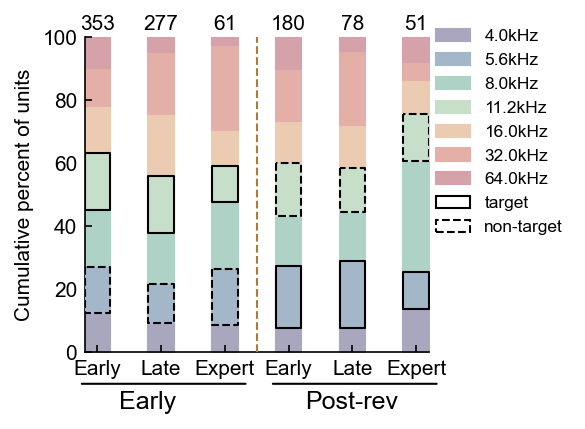

In [11]:
def plotBestFreqStack(ax,x,ylims,best_freqs,weights,width = 0.4,tntls=['-','-']):
    tones_250 = [4000,8000,16000,32000,64000]
    tones_350 = [4000,5648,8000,11260,16000,32000,64000]
    tones_450 = [4000,5648,8000,11260,16000,22627,32000,45255,64000]
    freqs_to_consider = tones_350
    cmap = mpl.cm.get_cmap('Set2')
    #colors_to_use = cmap(np.linspace(0,1,len(freqs_to_consider)))
    #colors_to_use = ['#80689D','#4D4C55','#78B0AC','#a4b49c','#76a5af','#3d85c6','#B6888E']
    colors_to_use = ['#A9A7BE','#A4B7C9','#AED2C6','#C7DEC8','#ECCBB3','#E4AFA7','#D5A2A9']
    for idx,color in enumerate(colors_to_use):
        r,g,b = mpl.colors.to_rgb(color)
        h,l,s = colorsys.rgb_to_hls(r,g,b)
        color=np.concatenate([colorsys.hls_to_rgb(h,(1-(1-l)*1)*1,s*1),[1]])
        colors_to_use[idx] = color
    #colors_to_use = mpl.colors.Colormap('plasma',len(freqs_to_consider))
    
    total_weight = 0
    for tone in freqs_to_consider:
        this_tone_idx = np.equal(best_freqs,tone)
        total_weight += np.sum(weights[this_tone_idx])
        
    current_total = 0
    last_breakpoints = []
    breakpoints = [0]
    for idx,tone in enumerate(freqs_to_consider):
        this_tone_idx = np.equal(best_freqs,tone)
        this_tone_weight = np.sum(weights[this_tone_idx])
        if tone == 5648:
            ax.fill_between([x-width/2,x+width/2],[current_total/total_weight]*2,[(current_total+this_tone_weight)/total_weight]*2,color=colors_to_use[idx],lw=1)
            ax.fill_between([x-width/2,x+width/2],[current_total/total_weight]*2,[(current_total+this_tone_weight)/total_weight]*2,color=colors_to_use[idx],lw=1,linestyle=tntls[0],edgecolor='k',zorder=10)#,hatch='XXXXXX'
        elif tone == 11260:
            ax.fill_between([x-width/2,x+width/2],[current_total/total_weight]*2,[(current_total+this_tone_weight)/total_weight]*2,color=colors_to_use[idx],lw=1)
            ax.fill_between([x-width/2,x+width/2],[current_total/total_weight]*2,[(current_total+this_tone_weight)/total_weight]*2,color=colors_to_use[idx],lw=1,linestyle=tntls[1],edgecolor='k',zorder=10)
        else:
            ax.fill_between([x-width/2,x+width/2],[current_total/total_weight]*2,[(current_total+this_tone_weight)/total_weight]*2,color=colors_to_use[idx],lw=1)
        current_total += this_tone_weight
        breakpoints.append(current_total)
        
    return (breakpoints/total_weight)

def plotConnectingLines(breakpre,breakpost,X,width=0.125):
    cmap = mpl.cm.get_cmap('Set2')
    #colors_to_use = ['#80689D','#4D4C55','#78B0AC','#a4b49c','#76a5af','#3d85c6','#B6888E']
    #colors_to_use = ['#b6888e','#80689D','#3d85c6','#78a5af','#78b0ac','#a4b49c','#4d4c55']
    colors_to_use = ['#A9A7BE','#A4B7C9','#AED2C6','#C7DEC8','#ECCBB3','#E4AFA7','#D5A2A9']
    for idx,color in enumerate(colors_to_use):
        r,g,b = mpl.colors.to_rgb(color)
        h,l,s = colorsys.rgb_to_hls(r,g,b)
        color=np.concatenate([colorsys.hls_to_rgb(h,(1-(1-l)*1)*1,s*1),[1]])
        colors_to_use[idx] = color
        
        Y1 = [breakpre[idx],breakpost[idx]]
        Y2 = [breakpre[idx+1],breakpost[idx+1]]
        Xplot = [X[0]+width,X[1]-width]
        
        ax.fill_between(Xplot,Y1,Y2,color=colors_to_use[idx],alpha=0.125,lw=0,zorder=-30)

fig,ax = plt.subplots(figsize=(4,3))
breakspreEa = plotBestFreqStack(ax,0,[],pre_early_best_freqs,pre_early_weights,tntls=['--','-'])
breakspreLa = plotBestFreqStack(ax,1,[],pre_late_best_freqs,pre_late_weights,tntls=['--','-'])
#plotConnectingLines(breakspreEa,breakspreLa,[0,1])
breakspreEx = plotBestFreqStack(ax,2,[],pre_expert_best_freqs,pre_expert_weights,tntls=['--','-'])
#plotConnectingLines(breakspreLa,breakspreEx,[1,2])
breakspostEa = plotBestFreqStack(ax,3,[],post_early_best_freqs,post_early_weights,tntls=['-','--'])
#plotConnectingLines(breakspreEx,breakspostEa,[2,3])
breakspostLa = plotBestFreqStack(ax,4,[],post_late_best_freqs,post_late_weights,tntls=['-','--'])
#plotConnectingLines(breakspostEa,breakspostLa,[3,4])
breakspostEx = plotBestFreqStack(ax,5,[],post_expert_best_freqs,post_expert_weights,tntls=['-','--'])
#plotConnectingLines(breakspostLa,breakspostEx,[4,5])

tones_250 = [4000,8000,16000,32000,64000]
tones_350 = [4000,5648,8000,11260,16000,32000,64000]
tones_450 = [4000,5648,8000,11260,16000,22627,32000,45255,64000]
tones_to_use = tones_350
cmap = mpl.cm.get_cmap('Set2')
colors_to_use = ['#A9A7BE','#A4B7C9','#AED2C6','#C7DEC8','#ECCBB3','#E4AFA7','#D5A2A9']
for idx,tone in enumerate(tones_to_use):
    ax.fill_between([],[],[],color = colors_to_use[idx],label=str(np.floor(tone/100)/10)+'kHz',lw=1)
ax.fill_between([],[],[],color = 'white', ec = 'k', lw=1, linestyle='-',label='target')
ax.fill_between([],[],[],color = 'white', ec = 'k', lw=1, linestyle='--',label='non-target')

labels = ['Early','Late','Expert','Early','Late','Expert']
#labels = ['Early','Late\n\nPre-reversal','Expert','Early','Late\n\nPost-reversal','Expert']
ax.set_xlim([-0.2,5.2])
ax.set_xticks(range(6))
ax.set_xticklabels(labels)
ax.set_xlim(ax.get_xlim())
ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)

ax.set_ylim([0,1])
ax.set_yticks([0,0.2,0.4,0.6,0.8,1])
ax.set_yticklabels(['0','20','40','60','80','100'])
ax.set_ylabel('Cumulative percent of units')

ax.legend(frameon=False,loc=[1,0.35])

ax.text(0,1.01,int(np.sum(pre_early_weights)),horizontalalignment='center',verticalalignment='bottom',fontsize=10)
ax.text(1,1.01,int(np.sum(pre_late_weights)),horizontalalignment='center',verticalalignment='bottom',fontsize=10)
ax.text(2,1.01,int(np.sum(pre_expert_weights)),horizontalalignment='center',verticalalignment='bottom',fontsize=10)
ax.text(3,1.01,int(np.sum(post_early_weights)),horizontalalignment='center',verticalalignment='bottom',fontsize=10)
ax.text(4,1.01,int(np.sum(post_late_weights)),horizontalalignment='center',verticalalignment='bottom',fontsize=10)
ax.text(5,1.01,int(np.sum(post_expert_weights)),horizontalalignment='center',verticalalignment='bottom',fontsize=10)

ax.annotate('', xy=(-0.02, -0.1), xycoords='axes fraction', xytext=(0.48, -0.1),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.535, -0.1), xycoords='axes fraction', xytext=(1.035, -0.1),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('Early', xy=(0.1, -0.18), xycoords='axes fraction', xytext=(0.1, -0.18),color='black',fontsize=12)
ax.annotate('Post-rev', xy=(0.64, -0.18), xycoords='axes fraction', xytext=(0.64, -0.18),color='black',fontsize=12)

plt.tight_layout()


#fig.savefig(os.path.join('/Users/InsanallyLab/Desktop/Tiange Mac Folder/Figures','Best frequency over learning with TH_217.pdf'),transparent=False,facecolor="white")
fig.savefig(os.path.join ('C:\\\\Users\\insan\\Desktop\\Figures','Best frequency over learning with TH_217.pdf'),transparent=False,facecolor="white")

meta NOT subset; don't know how to subset; dropped


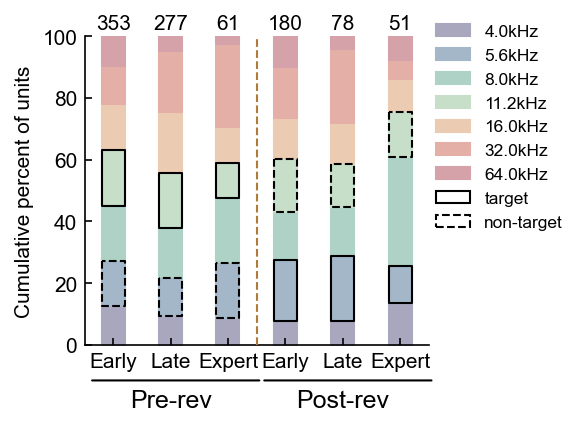

In [12]:
def plotBestFreqStack(ax,x,ylims,best_freqs,weights,width = 0.4,tntls=['-','-']):
    tones_250 = [4000,8000,16000,32000,64000]
    tones_350 = [4000,5648,8000,11260,16000,32000,64000]
    tones_450 = [4000,5648,8000,11260,16000,22627,32000,45255,64000]
    freqs_to_consider = tones_350
    cmap = mpl.cm.get_cmap('Set2')
    #colors_to_use = cmap(np.linspace(0,1,len(freqs_to_consider)))
    #colors_to_use = ['#80689D','#4D4C55','#78B0AC','#a4b49c','#76a5af','#3d85c6','#B6888E']
    colors_to_use = ['#A9A7BE','#A4B7C9','#AED2C6','#C7DEC8','#ECCBB3','#E4AFA7','#D5A2A9']
    for idx,color in enumerate(colors_to_use):
        r,g,b = mpl.colors.to_rgb(color)
        h,l,s = colorsys.rgb_to_hls(r,g,b)
        color=np.concatenate([colorsys.hls_to_rgb(h,(1-(1-l)*1)*1,s*1),[1]])
        colors_to_use[idx] = color
    #colors_to_use = mpl.colors.Colormap('plasma',len(freqs_to_consider))
    
    total_weight = 0
    for tone in freqs_to_consider:
        this_tone_idx = np.equal(best_freqs,tone)
        total_weight += np.sum(weights[this_tone_idx])
        
    current_total = 0
    last_breakpoints = []
    breakpoints = [0]
    for idx,tone in enumerate(freqs_to_consider):
        this_tone_idx = np.equal(best_freqs,tone)
        this_tone_weight = np.sum(weights[this_tone_idx])
        if tone == 5648:
            ax.fill_between([x-width/2,x+width/2],[current_total/total_weight]*2,[(current_total+this_tone_weight)/total_weight]*2,color=colors_to_use[idx],lw=1)
            ax.fill_between([x-width/2,x+width/2],[current_total/total_weight]*2,[(current_total+this_tone_weight)/total_weight]*2,color=colors_to_use[idx],lw=1,linestyle=tntls[0],edgecolor='k',zorder=10)#,hatch='XXXXXX'
        elif tone == 11260:
            ax.fill_between([x-width/2,x+width/2],[current_total/total_weight]*2,[(current_total+this_tone_weight)/total_weight]*2,color=colors_to_use[idx],lw=1)
            ax.fill_between([x-width/2,x+width/2],[current_total/total_weight]*2,[(current_total+this_tone_weight)/total_weight]*2,color=colors_to_use[idx],lw=1,linestyle=tntls[1],edgecolor='k',zorder=10)
        else:
            ax.fill_between([x-width/2,x+width/2],[current_total/total_weight]*2,[(current_total+this_tone_weight)/total_weight]*2,color=colors_to_use[idx],lw=1)
        current_total += this_tone_weight
        breakpoints.append(current_total)
        
    return (breakpoints/total_weight)

def plotConnectingLines(breakpre,breakpost,X,width=0.125):
    cmap = mpl.cm.get_cmap('Set2')
    #colors_to_use = ['#80689D','#4D4C55','#78B0AC','#a4b49c','#76a5af','#3d85c6','#B6888E']
    #colors_to_use = ['#b6888e','#80689D','#3d85c6','#78a5af','#78b0ac','#a4b49c','#4d4c55']
    colors_to_use = ['#A9A7BE','#A4B7C9','#AED2C6','#C7DEC8','#ECCBB3','#E4AFA7','#D5A2A9']
    for idx,color in enumerate(colors_to_use):
        r,g,b = mpl.colors.to_rgb(color)
        h,l,s = colorsys.rgb_to_hls(r,g,b)
        color=np.concatenate([colorsys.hls_to_rgb(h,(1-(1-l)*1)*1,s*1),[1]])
        colors_to_use[idx] = color
        
        Y1 = [breakpre[idx],breakpost[idx]]
        Y2 = [breakpre[idx+1],breakpost[idx+1]]
        Xplot = [X[0]+width,X[1]-width]
        
        ax.fill_between(Xplot,Y1,Y2,color=colors_to_use[idx],alpha=0.125,lw=0,zorder=-30)

fig,ax = plt.subplots(figsize=(4,3))
breakspreEa = plotBestFreqStack(ax,0,[],pre_early_best_freqs,pre_early_weights,tntls=['--','-'])
breakspreLa = plotBestFreqStack(ax,1,[],pre_late_best_freqs,pre_late_weights,tntls=['--','-'])
#plotConnectingLines(breakspreEa,breakspreLa,[0,1])
breakspreEx = plotBestFreqStack(ax,2,[],pre_expert_best_freqs,pre_expert_weights,tntls=['--','-'])
#plotConnectingLines(breakspreLa,breakspreEx,[1,2])
breakspostEa = plotBestFreqStack(ax,3,[],post_early_best_freqs,post_early_weights,tntls=['-','--'])
#plotConnectingLines(breakspreEx,breakspostEa,[2,3])
breakspostLa = plotBestFreqStack(ax,4,[],post_late_best_freqs,post_late_weights,tntls=['-','--'])
#plotConnectingLines(breakspostEa,breakspostLa,[3,4])
breakspostEx = plotBestFreqStack(ax,5,[],post_expert_best_freqs,post_expert_weights,tntls=['-','--'])
#plotConnectingLines(breakspostLa,breakspostEx,[4,5])

tones_250 = [4000,8000,16000,32000,64000]
tones_350 = [4000,5648,8000,11260,16000,32000,64000]
tones_450 = [4000,5648,8000,11260,16000,22627,32000,45255,64000]
tones_to_use = tones_350
cmap = mpl.cm.get_cmap('Set2')
colors_to_use = ['#A9A7BE','#A4B7C9','#AED2C6','#C7DEC8','#ECCBB3','#E4AFA7','#D5A2A9']
for idx,tone in enumerate(tones_to_use):
    ax.fill_between([],[],[],color = colors_to_use[idx],label=str(np.floor(tone/100)/10)+'kHz',lw=1)
ax.fill_between([],[],[],color = 'white', ec = 'k', lw=1, linestyle='-',label='target')
ax.fill_between([],[],[],color = 'white', ec = 'k', lw=1, linestyle='--',label='non-target')

labels = ['Early','Late','Expert','Early','Late','Expert']
#labels = ['Early','Late\n\nPre-reversal','Expert','Early','Late\n\nPost-reversal','Expert']
#ax.set_xlim([-0.2,5.2])
ax.set_xlim([-0.5,5.5])
ax.set_xticks(range(6))
ax.set_xticklabels(labels)
ax.set_xlim(ax.get_xlim())
ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)

ax.set_ylim([0,1])
ax.set_yticks([0,0.2,0.4,0.6,0.8,1])
ax.set_yticklabels(['0','20','40','60','80','100'])
ax.set_ylabel('Cumulative percent of units')

ax.legend(frameon=False,loc=[1,0.35])

ax.text(0,1.01,int(np.sum(pre_early_weights)),horizontalalignment='center',verticalalignment='bottom',fontsize=10)
ax.text(1,1.01,int(np.sum(pre_late_weights)),horizontalalignment='center',verticalalignment='bottom',fontsize=10)
ax.text(2,1.01,int(np.sum(pre_expert_weights)),horizontalalignment='center',verticalalignment='bottom',fontsize=10)
ax.text(3,1.01,int(np.sum(post_early_weights)),horizontalalignment='center',verticalalignment='bottom',fontsize=10)
ax.text(4,1.01,int(np.sum(post_late_weights)),horizontalalignment='center',verticalalignment='bottom',fontsize=10)
ax.text(5,1.01,int(np.sum(post_expert_weights)),horizontalalignment='center',verticalalignment='bottom',fontsize=10)

# ax.annotate('', xy=(-0.02, -0.1), xycoords='axes fraction', xytext=(0.48, -0.1),arrowprops=dict(arrowstyle='-', color='black'))
# ax.annotate('', xy=(0.535, -0.1), xycoords='axes fraction', xytext=(1.035, -0.1),arrowprops=dict(arrowstyle='-', color='black'))
# ax.annotate('Early', xy=(0.1, -0.18), xycoords='axes fraction', xytext=(0.1, -0.18),color='black',fontsize=12)
# ax.annotate('Post-rev', xy=(0.64, -0.18), xycoords='axes fraction', xytext=(0.64, -0.18),color='black',fontsize=12)
#Add line
ax.annotate('', xy=(0.01, -0.115), xycoords='axes fraction', xytext=(0.52, -0.115),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.51, -0.115), xycoords='axes fraction', xytext=(1.02, -0.115),arrowprops=dict(arrowstyle='-', color='black'))
# get the x-position of the second tick label
xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
# add the text under the second label
# ax.annotate('Pre-rev', xy=(0.11, -0.18), xycoords='axes fraction', color='black',fontsize=12)
# ax.annotate('Post-rev', xy=(0.65, -0.18), xycoords='axes fraction', color='black',fontsize=12)
#ax.annotate('Post-rev', xy=(0.65, -0.18), xycoords='axes fraction', color='black',fontsize=12)

# get the x-position of the second tick label
xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
# add the text under the second label
ax.text(xtick_pos_pre,ax.get_ylim()[0]-0.18, 'Pre-rev', ha='center', va='center', fontsize=12)
ax.text(xtick_pos_post,ax.get_ylim()[0]-0.18, 'Post-rev', ha='center', va='center', fontsize=12)

plt.tight_layout()


#fig.savefig(os.path.join('/Users/InsanallyLab/Desktop/Tiange Mac Folder/Figures','Best frequency over learning with TH_217.pdf'),transparent=False,facecolor="white")
fig.savefig(os.path.join ('C:\\\\Users\\insan\\Desktop\\Figures','Best frequency over learning with TH_217.pdf'),transparent=False,facecolor="white")